# Loading the dataset

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from torchvision.datasets import CocoCaptions
from torchvision.transforms import transforms
import nltk
from sklearn.cluster import KMeans
from gensim.models import KeyedVectors

In [2]:
nltk.download('averaged_perceptron_tagger') # requires internet

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aumpa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Define paths for datasets
data_type = 'train2014' # or 'val2014' 
captions_file = f'archive/captions/annotations/captions_{data_type}.json'
image_dir = f'archive/images/{data_type}'

# Apply a series of Augmentations to data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = CocoCaptions(root=image_dir, annFile=captions_file, transform=transform)

loading annotations into memory...
Done (t=2.07s)
creating index...
index created!


In [ ]:
dataset[0] # first image, returns a tuple (tensor, list)

In [5]:
type(dataset)

torchvision.datasets.coco.CocoCaptions

In [6]:
dataset[0][1] # returns list of captions for the first image

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [7]:
dataset[0][1][2]

'there are containers filled with different kinds of foods'

### Creating `master_list`:

In [ ]:
# master_list is the list of all words extracted from all captions.
# creating the master list:

master_list = []
translator = str.maketrans('', '', string.punctuation)
for i in range(len(dataset)):
    current_caption = dataset[i][1]
    for k in range(len(current_caption)):
        current_string = current_caption[k]
        current_string = current_string.translate(translator) # remove punctuation symbols from current_string
        master_list.extend(current_string.split(" "))

In [ ]:
master_list

In [9]:
# convert all words in master_list to lowercase:

master_list = [word.lower() for word in master_list]
# master_list

# General quantitative analysis

### Number of images in the dataset

In [10]:
print(f"Number of images in the dataset = {len(dataset)}")

Number of images in the dataset = 82783


### Number of captions

In [11]:
caption_to_image_ratio = len(dataset[0][1])
total_captions = len(dataset[0][1]) * len(dataset)
word_to_image_ratio = len(master_list) / len(dataset) # first load the full master_list in memory

print(f"Caption to image ratio = {caption_to_image_ratio}")
print(f"Total number of captions in the dataset = {total_captions}")
print(f"Total number of words in all captions = {len(master_list)}")
print(f"Average number of words that describe an image = {word_to_image_ratio}")

Caption to image ratio = 5
Total number of captions in the dataset = 413915
Total number of words in all captions = 85261
Average number of words that describe an image = 1.0299336820361669


### Number of unique words in the dataset

C:\Users\aumpa\AppData\Local\Temp\ipykernel_10264\2233429665.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(word_types, rotation=90) # Set the x-tick labels vertically


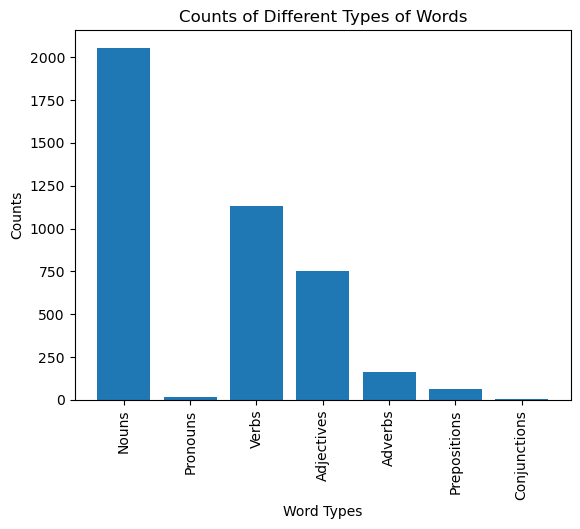

NOTE: Total number of unique words in dataset = 4297


In [12]:
master_list_unique = list(set(word.lower() for word in master_list)) # list of unique words in the master_list
num_of_unique_words = len(master_list_unique)
nouns = [word for (word, pos) in nltk.pos_tag(master_list_unique) if pos.startswith('N')] # list of all nouns in master_list_unique
pronouns = [word[0] for word in nltk.pos_tag(master_list_unique) if word[1] == "PRP"]
verbs = [word[0] for word in nltk.pos_tag(master_list_unique) if word[1].startswith("VB")]
adjectives = [word[0] for word in nltk.pos_tag(master_list_unique) if word[1] == "JJ"]
adverbs = [word[0] for word in nltk.pos_tag(master_list_unique) if word[1] == "RB"]
prepositions = [word[0] for word in nltk.pos_tag(master_list_unique) if word[1] == "IN"]
conjunctions = [word[0] for word in nltk.pos_tag(master_list_unique) if word[1] == "CC"]

counts = [len(nouns), len(pronouns), len(verbs), len(adjectives), len(adverbs), len(prepositions), len(conjunctions)]
word_types = ["Nouns", "Pronouns", "Verbs", "Adjectives", "Adverbs", "Prepositions", "Conjunctions"]
fig, ax = plt.subplots() # Create the bar plot
ax.bar(word_types, counts)
ax.set_xticklabels(word_types, rotation=90) # Set the x-tick labels vertically
ax.set_title("Counts of Different Types of Words")
ax.set_xlabel("Word Types")
ax.set_ylabel("Counts")
plt.show() # display the plot

print(f"NOTE: Total number of unique words in dataset = {num_of_unique_words}")

# Semantically clustering the words in `master_list`

Find the pre-trained word2vec model [here](https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300).

In [13]:
# load pre-trained word embeddings
word_vectors = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True) # 3.39 GB file

In [14]:
# create a list of word embeddings
embeddings = []
for word in master_list_unique:
    if word in word_vectors:
        embeddings.append(word_vectors[word])

# determine the number of clusters using the elbow method
distortions = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(embeddings) # n_init="auto", else it gives warnings for each cluster
    distortions.append(kmeans.inertia_)
    
num_clusters = np.argmin(distortions) + 1

# perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

# print the clusters
for i in range(num_clusters):
    cluster = np.where(kmeans.labels_ == i)[0]
    words = [master_list_unique[j] for j in cluster]
    # print(f"Cluster {i+1}: {words}")

C:\Users\aumpa\anaconda3\envs\img_caption\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Optimal number of clusters (K) using elbow method

More is the value of K, more diverse is the dataset.

In [15]:
num_clusters # comparing `distortion` for K-value ranging from 1 to 30

30

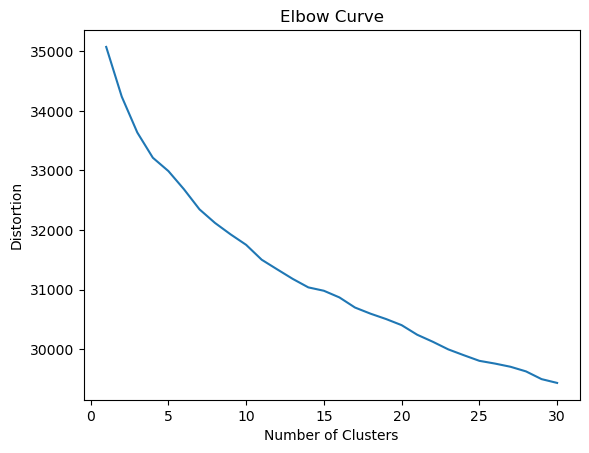

In [16]:
plt.plot(range(1, 31), distortions)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

Slope of above curve becomes low rapidly at K=10.